In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [4]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'    

'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.


## Set-up

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

ModuleNotFoundError: No module named 'torch'

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    
    # Trier les annotations par ordre de surface décroissant
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    # Créer une image transparente pour afficher les masques colorés
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0  # Calque alpha pour la transparence
    
    # Boucle à travers chaque annotation pour afficher le masque et le contour
    for idx, ann in enumerate(sorted_anns, 1):
        # Si la surface est trop petite, passer au suivant
        if ann['area'] < 1000:
            continue
        
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.05]])  # Couleur aléatoire avec transparence
        
        # Appliquer le masque coloré
        img[m] = color_mask
        
        # Créer un contour autour de la détection
        contours = plt.contour(m, levels=[0.5], colors=[color_mask[:3]], linewidths=1.5)
        
        # Ajouter un numéro au centre de la détection
        y, x = np.mean(np.argwhere(m), axis=0)
        ax.text(x, y, str(idx), color='white', fontsize=12, ha='center', va='center', fontweight='bold')
    
    ax.imshow(img)

## Example image

In [ ]:
image = cv2.imread('Image/Echantillion1Mod2_301.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

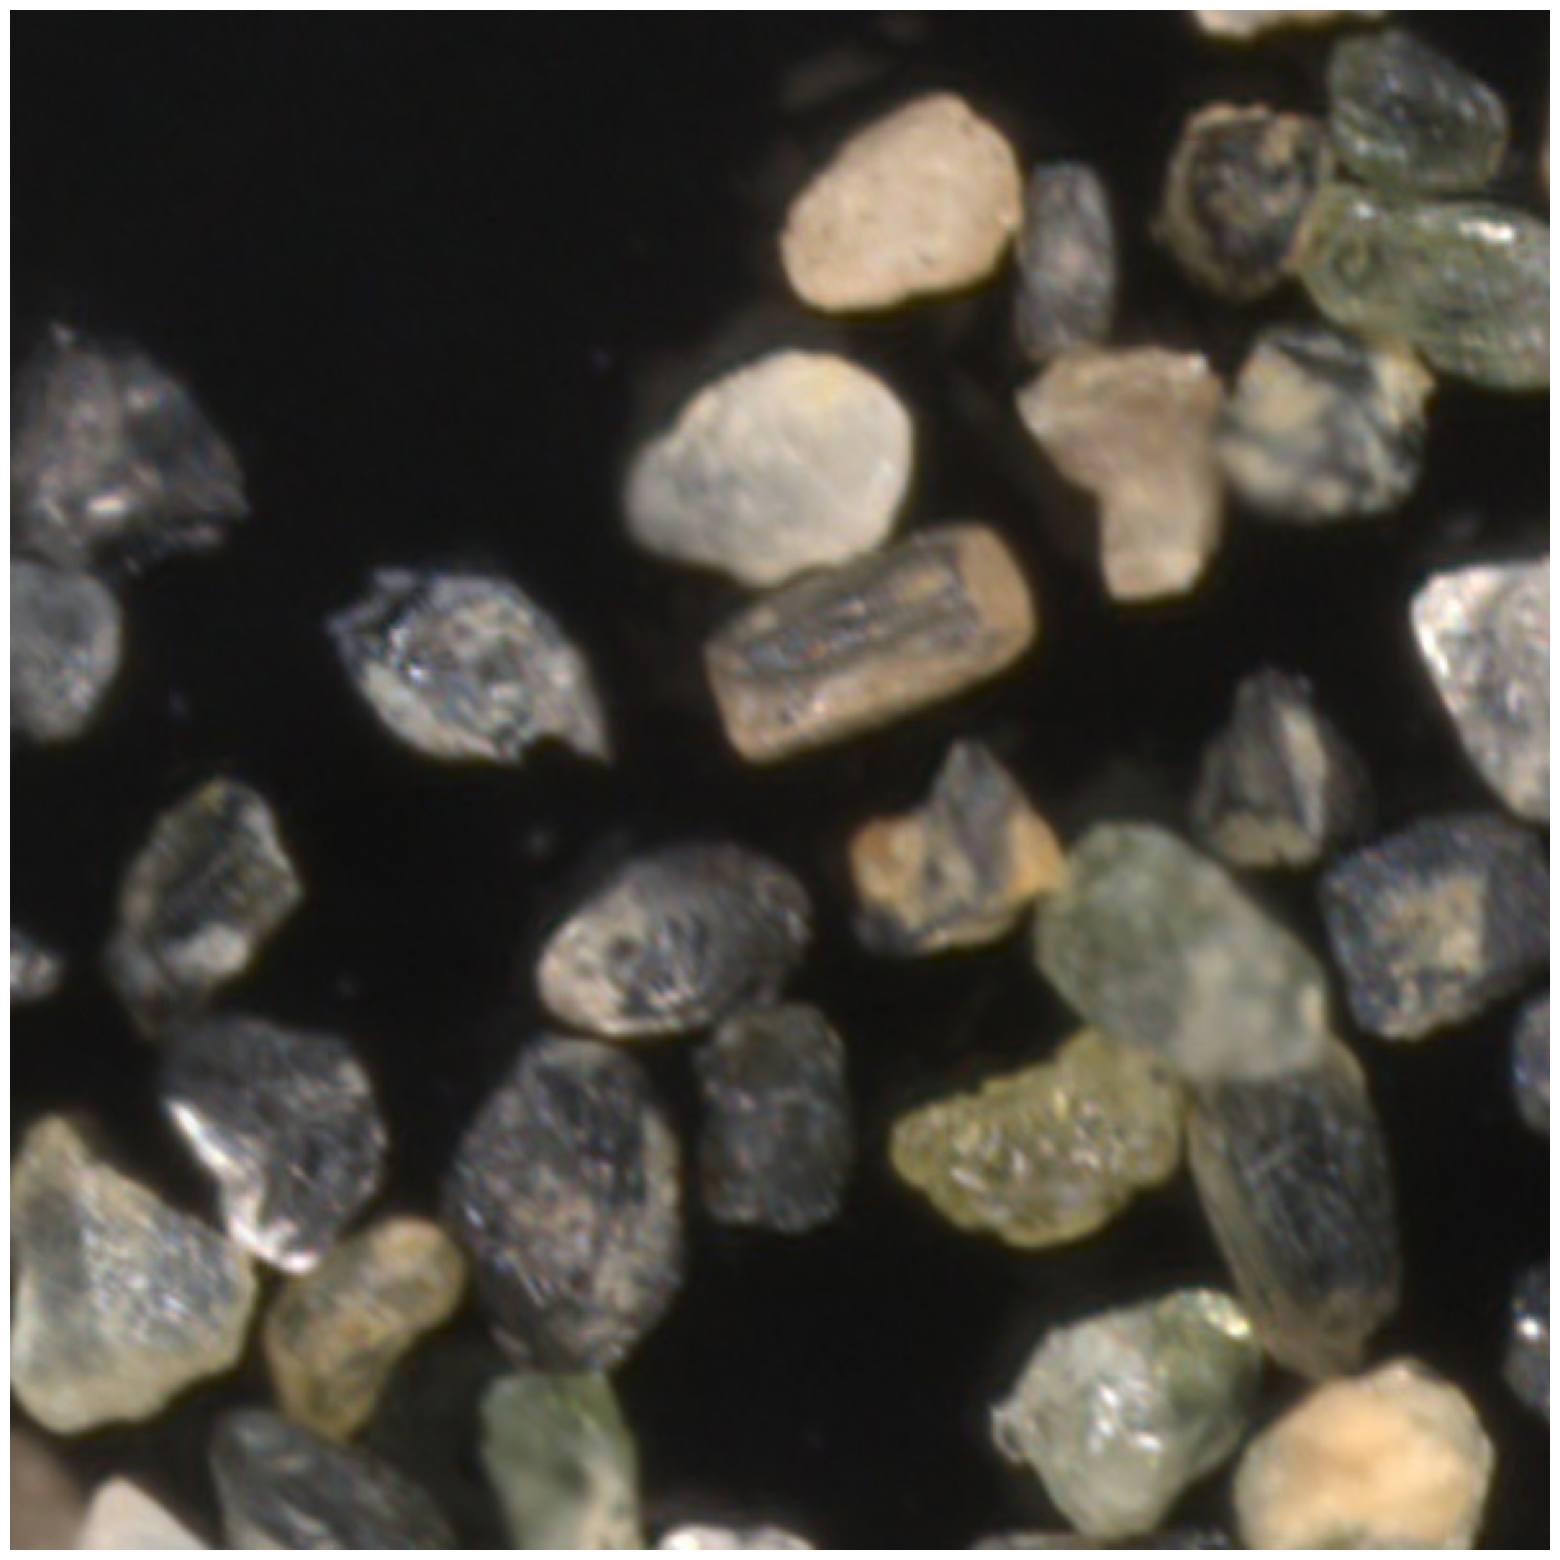

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

70
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

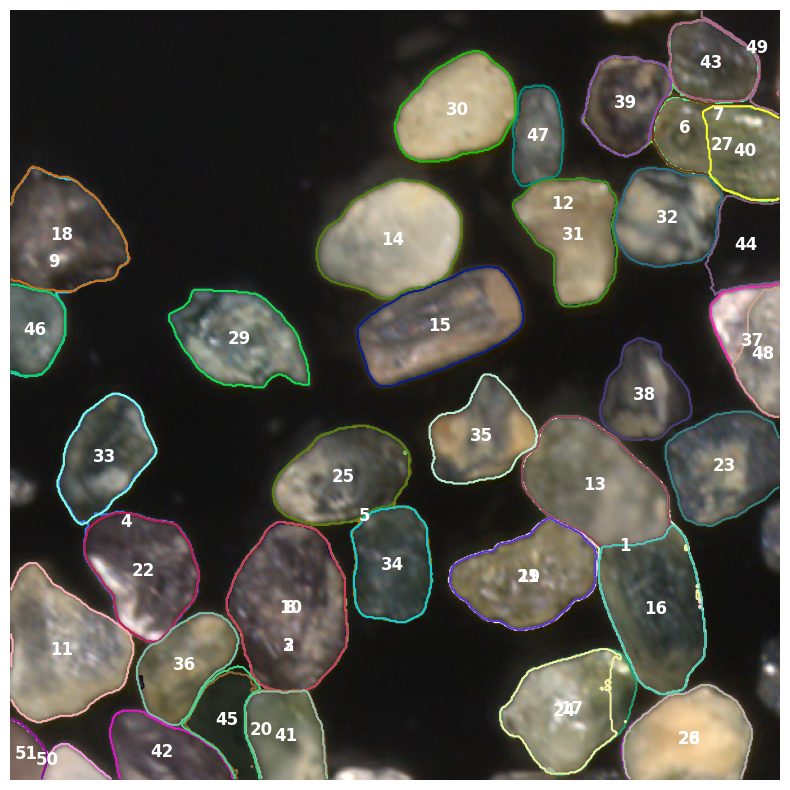

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 